<a href="https://colab.research.google.com/github/sudhanezraa2005-glitch/Projects/blob/main/Geo_clustering_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
from tqdm import tqdm
import requests
USE_DRIVE = True

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/data/"
else:
    BASE_PATH = "/content/"

geo = pd.read_csv(BASE_PATH + "geo_clustering.csv")
pinlat = pd.read_csv(BASE_PATH + "All-India-Pincode-list-with-latitude-and-longitude.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# ====== CONFIG ======
USE_DRIVE = True

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/data/"
else:
    BASE_PATH = "/content/"

geo = pd.read_csv(BASE_PATH + "geo_clustering.csv")
pinlat = pd.read_csv(BASE_PATH + "All-India-Pincode-list-with-latitude-and-longitude.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:


geo.rename(columns={"destination-pin": "Pincode"}, inplace=True)

geo["Pincode"] = geo["Pincode"].astype(int)
pinlat["Pincode"] = pinlat["Pincode"].astype(int)

pinlat_small = pinlat[["Pincode", "Latitude", "Longitude"]]

pd1 = pd.merge(geo, pinlat_small, on="Pincode", how="left")

pd1.to_csv("geo_clustering_with_latlon.csv", index=False)
pd1.head()


,Unnamed: 0,booking-date-time,Pincode,destination-office-name,event-code,event-description,event-office-name,non-delivery-reason-description,Latitude,Longitude
0,0,2025/11/08T00:00:00,563127,Devarayasamudra S.O,ID,Item Delivered,Devarayasamudra S.O,Item Delivered to venkatachalapati,13.129784,78.317474
1,0,2025/11/08T00:00:00,563127,Devarayasamudra S.O,ID,Item Delivered,Devarayasamudra S.O,Item Delivered to venkatachalapati,13.129784,78.317474
2,0,2025/11/08T00:00:00,563127,Devarayasamudra S.O,ID,Item Delivered,Devarayasamudra S.O,Item Delivered to venkatachalapati,13.129784,78.317474
3,0,2025/11/08T00:00:00,563127,Devarayasamudra S.O,ID,Item Delivered,Devarayasamudra S.O,Item Delivered to venkatachalapati,13.129784,78.317474
4,0,2025/11/08T00:00:00,563127,Devarayasamudra S.O,ID,Item Delivered,Devarayasamudra S.O,Item Delivered to venkatachalapati,13.129784,78.317474


K means clustering without statewise

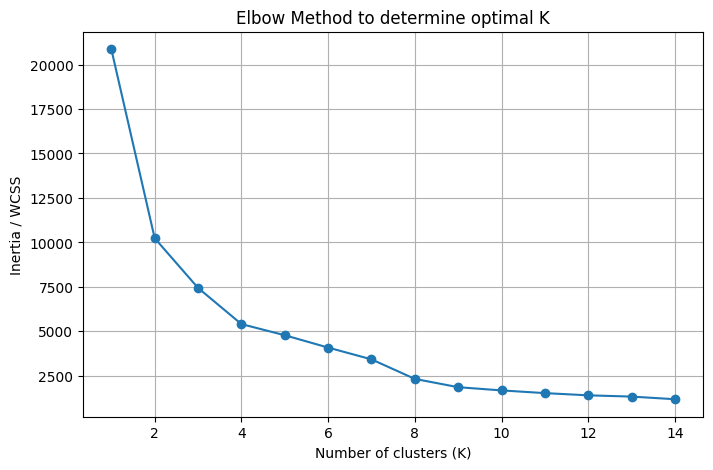

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X = pd1[["Latitude", "Longitude"]].dropna()

inertia = []

K_values = range(1, 15)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_values, inertia, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia / WCSS")
plt.title("Elbow Method to determine optimal K")
plt.grid(True)
plt.show()


K = 2, Silhouette Score = 0.5146
K = 3, Silhouette Score = 0.4818
K = 4, Silhouette Score = 0.4271
K = 5, Silhouette Score = 0.4159
K = 6, Silhouette Score = 0.4283
K = 7, Silhouette Score = 0.4046
K = 8, Silhouette Score = 0.4578
K = 9, Silhouette Score = 0.4704
K = 10, Silhouette Score = 0.4528
K = 11, Silhouette Score = 0.4521
K = 12, Silhouette Score = 0.4601
K = 13, Silhouette Score = 0.4509
K = 14, Silhouette Score = 0.4719


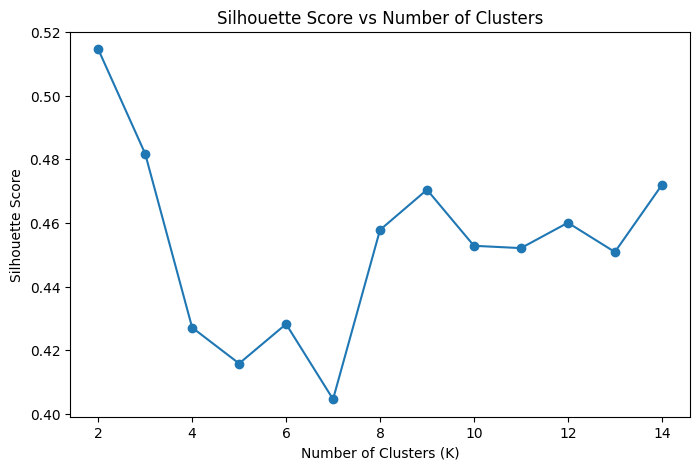

In [13]:
from sklearn.metrics import silhouette_score


X = pd1[["Latitude", "Longitude"]].dropna()

sil_scores = []
K_values = range(2, 15)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)
    print(f"K = {k}, Silhouette Score = {score:.4f}")

plt.figure(figsize=(8,5))
plt.plot(K_values, sil_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")

plt.show()


In [14]:

k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
pd1.loc[X.index, "cluster"] = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_
print("\nCluster Centers (Latitude, Longitude):")
print(centers)


Cluster Centers (Latitude, Longitude):
[[12.7726816  77.03193232]
 [17.05872008 78.14993793]
 [15.42274116 75.95902005]]


In [15]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

pd1['Latitude']  = pd.to_numeric(pd1['Latitude'], errors='coerce')
pd1['Longitude'] = pd.to_numeric(pd1['Longitude'], errors='coerce')
pd1['cluster']   = pd.to_numeric(pd1['cluster'], errors='coerce').astype('Int64')

plot_df = pd1.dropna(subset=['Latitude','Longitude','cluster']).copy()

centroids_df = pd.DataFrame(centers, columns=['Latitude','Longitude'])
centroids_df['cluster'] = centroids_df.index.astype(int)

fig = px.scatter_mapbox(
    plot_df,
    lat='Latitude',
    lon='Longitude',
    color='cluster',
    hover_name=plot_df.get('Pincode', None),
    hover_data=[c for c in ['destination-office-name','event-office-name','Pincode'] if c in plot_df.columns],
    zoom=5,
    height=700,
    mapbox_style='open-street-map',
    opacity=0.7
)

fig.add_trace(go.Scattermapbox(
    lat=centroids_df['Latitude'],
    lon=centroids_df['Longitude'],
    mode='markers+text',
    marker=go.scattermapbox.Marker(size=14, color='black'),
    text=['C'+str(int(c)) for c in centroids_df['cluster']],
    textposition='top center',
    name='Centroids'
))

fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
fig.show()


In [13]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install --force-reinstall scikit-learn-extra


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 75.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... canceled
^C


In [1]:
!pip install scikit-learn-extra


  Using cached scikit-learn-extra-0.3.0.tar.gz (818 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=1959510 sha256=1bbc30ee6f09cdf145d3a4423cbba138af7f74305c7d23a354e4ac5689ff3168
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [3]:
from sklearn_extra.cluster import KMedoids


In [16]:
data = pd1.dropna(subset=["Latitude", "Longitude"]).copy()
coords = data[["Latitude", "Longitude"]].to_numpy()


In [17]:
pd1 = pd1.rename(columns={
    "Latitude": "lat",
    "Longitude": "lon"
})

data = pd1.dropna(subset=["lat", "lon"]).copy()
coords = data[["lat", "lon"]].to_numpy()


In [18]:
!pip install pyclustering


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=53f5b21e6932fb4ce857d6192682ceec038166f8e3b0c91cd4d7f3f035ba5472
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


In [19]:
import pandas as pd
import numpy as np
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric


In [20]:
k = 3
initial_medoids = np.random.choice(len(coords), k, replace=False).tolist()


In [21]:
metric = distance_metric(type_metric.EUCLIDEAN)

kmedoids_instance = kmedoids(
    data=coords,
    initial_index_medoids=initial_medoids,
    metric=metric
)

kmedoids_instance.process()


In [22]:
clusters = kmedoids_instance.get_clusters()
medoid_indices = kmedoids_instance.get_medoids()


In [23]:
labels = np.zeros(len(coords), dtype=int)

for cluster_id, points in enumerate(clusters):
    for point in points:
        labels[point] = cluster_id

data["cluster"] = labels


In [24]:
hubs = data.iloc[medoid_indices][["Pincode", "lat", "lon"]]

print("Hub locations (K-Medoids):")
print(hubs)


Hub locations (K-Medoids):
      Pincode        lat        lon
3685   577552  14.193316  75.989029
3891   562109  12.785654  77.347351
2649   584127  16.089033  76.309837


In [25]:
fig = px.scatter_mapbox(
    data,
    lat="lat",
    lon="lon",
    color="cluster",
    zoom=4,
    height=600,
    mapbox_style="open-street-map",
    title="K-Medoids Clustering with Hub Locations"
)


In [26]:
fig.add_trace(
    go.Scattermapbox(
        lat=hubs["lat"],
        lon=hubs["lon"],
        mode="markers+text",
        marker=dict(
            size=30,                 # BIG point
            color="red",
            opacity=0.6,
            symbol="circle"          # dotted-style circle
        ),
        text=hubs["Pincode"].astype(str),
        textposition="top center",
        name="Hub Location"
    )
)


In [ ]:
!pip install requests tqdm


In [27]:

from tqdm import tqdm


In [28]:
def osrm_distance_matrix(coords):
    """
    coords: array of shape (N, 2) -> [lat, lon]
    returns NxN distance matrix in meters
    """
    coord_str = ";".join([f"{lon},{lat}" for lat, lon in coords])

    url = f"http://router.project-osrm.org/table/v1/driving/{coord_str}?annotations=distance"

    r = requests.get(url)
    r.raise_for_status()

    return np.array(r.json()["distances"])


In [29]:
def find_osrm_medoid(cluster_df):
    coords = cluster_df[["lat", "lon"]].to_numpy()

    # If cluster too large, subsample
    if len(coords) > 100:
        cluster_df = cluster_df.sample(100, random_state=42)
        coords = cluster_df[["lat", "lon"]].to_numpy()

    dist_matrix = osrm_distance_matrix(coords)
    total_cost = dist_matrix.sum(axis=1)

    medoid_idx = np.argmin(total_cost)
    return cluster_df.iloc[medoid_idx]


In [30]:
osrm_hubs = []

for cluster_id in sorted(data["cluster"].unique()):
    cluster_df = data[data["cluster"] == cluster_id]
    hub = find_osrm_medoid(cluster_df)
    osrm_hubs.append(hub)

osrm_hubs = pd.DataFrame(osrm_hubs)[["Pincode", "lat", "lon", "cluster"]]


In [31]:
print(osrm_hubs)


      Pincode        lat        lon  cluster
2699   577213  14.005256  75.944946        0
1030   562159  12.715999  77.284096        1
4337   583277  15.754394  76.204613        2


In [32]:
import requests

def osrm_route(lat1, lon1, lat2, lon2):
    url = (
        f"http://router.project-osrm.org/route/v1/driving/"
        f"{lon1},{lat1};{lon2},{lat2}"
        f"?overview=full&geometries=geojson"
    )
    r = requests.get(url)
    r.raise_for_status()
    return r.json()["routes"][0]["geometry"]["coordinates"]


In [33]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_mapbox(
    data,
    lat="lat",
    lon="lon",
    color="cluster",
    zoom=4,
    height=650,
    mapbox_style="open-street-map",
    title="OSRM-Based Hub Location with Road Connectivity"
)


In [34]:
fig.add_trace(
    go.Scattermapbox(
        lat=osrm_hubs["lat"],
        lon=osrm_hubs["lon"],
        mode="markers+text",
        marker=dict(
            size=30,
            color="red",
            opacity=0.6
        ),
        text=osrm_hubs["Pincode"].astype(str),
        textposition="top center",
        name="Hub (OSRM Medoid)"
    )
)


In [35]:
import numpy as np

for cluster_id in data["cluster"].unique():
    cluster_df = data[data["cluster"] == cluster_id]
    hub = osrm_hubs[osrm_hubs["cluster"] == cluster_id].iloc[0]

    # Sample points to avoid clutter
    sample_df = cluster_df.sample(
        min(12, len(cluster_df)), random_state=42
    )

    for _, row in sample_df.iterrows():
        coords = osrm_route(
            hub["lat"], hub["lon"],
            row["lat"], row["lon"]
        )

        lons, lats = zip(*coords)

        fig.add_trace(
            go.Scattermapbox(
                lat=lats,
                lon=lons,
                mode="lines",
                line=dict(width=2),
                opacity=0.6,
                showlegend=False
            )
        )


Map using Real Road connections , destination and potetnial hubs

In [36]:
fig.show()


State wise **clustering**

In [41]:
import pandas as pd


df = pd.read_csv(BASE_PATH +"geo_clustering.csv")


pincode_df = pd.read_csv(BASE_PATH +"All-India-Pincode-list-with-latitude-and-longitude.csv")

pincode_df.rename(columns={
    "Pincode": "destination-pin",
    "StateName": "state"
}, inplace=True)

df = df.merge(
    pincode_df[["destination-pin", "State", "Latitude", "Longitude"]],
    on="destination-pin",
    how="left"
)



In [40]:
pincode_df.head()

,CID,CityName/AreaName,destination-pin,District,State,Latitude,Longitude
0,1,Baroda House,110001,Central Delhi,DELHI,28.628075,77.21785
1,2,Bengali Market,110001,Central Delhi,DELHI,28.628075,77.21785
2,3,Bhagat Singh Market,110001,Central Delhi,DELHI,28.628075,77.21785
3,4,Connaught Place,110001,Central Delhi,DELHI,28.628075,77.21785
4,5,Constitution House,110001,Central Delhi,DELHI,28.628075,77.21785


In [64]:
df['State'].unique()

array(['KARNATAKA', 'KERALA', 'ANDHRA PRADESH', 'TELANGANA', 'TAMIL NADU',
       'GOA', 'ODISHA'], dtype=object)

In [65]:
# drop rows where state or coordinates are missing
df = df.dropna(subset=["State", "Latitude", "Longitude"])
df['State'].unique()

array(['KARNATAKA', 'KERALA', 'ANDHRA PRADESH', 'TELANGANA', 'TAMIL NADU',
       'GOA', 'ODISHA'], dtype=object)

In [46]:
state_dfs = {
    state: data
    for state, data in df.groupby("State")
}


In [50]:
def best_k(X, k_range=range(2, 7)):
    """
    Returns optimal k using silhouette score.
    Handles duplicate coordinates safely.
    """

    X_unique = X.drop_duplicates()

    # if only one geographic point → no clustering possible
    if len(X_unique) < 2:
        return 1

    best_score = -1
    best_k_val = 2

    for k in k_range:
        if k >= len(X_unique):
            break

        labels = KMeans(
            n_clusters=k,
            random_state=42,
            n_init=10
        ).fit_predict(X_unique)

        # silhouette requires at least 2 clusters
        if len(set(labels)) < 2:
            continue

        score = silhouette_score(X_unique, labels)

        if score > best_score:
            best_score = score
            best_k_val = k

    return best_k_val


In [51]:
clustered_states = {}

for state, sdf in state_dfs.items():

    X = sdf[["Latitude", "Longitude"]]

    # remove duplicates for geo validation
    unique_points = X.drop_duplicates()

    # CASE 1: only one location in the state
    if len(unique_points) < 2:
        sdf["cluster"] = 0
        clustered_states[state] = sdf
        continue

    # find optimal k
    k = best_k(X)

    # CASE 2: silhouette forced single cluster
    if k == 1:
        sdf["cluster"] = 0
    else:
        sdf["cluster"] = KMeans(
            n_clusters=k,
            random_state=42,
            n_init=10
        ).fit_predict(X)

    clustered_states[state] = sdf


In [74]:
final_df["state_cluster"] = (
    final_df["State"].astype(str) + "_C" + final_df["cluster"].astype(str)
)


In [83]:
# compute centroids per (State, cluster)
centroids = (
    final_df
    .groupby(["State", "cluster"], as_index=False)
    .agg({
        "Latitude": "mean",
        "Longitude": "mean"
    })
)

centroids.head(20)


,State,cluster,Latitude,Longitude
0,ANDHRA PRADESH,0,18.475330,84.078889
1,ANDHRA PRADESH,1,16.137453,80.165534
2,ANDHRA PRADESH,2,14.947524,77.440858
3,ANDHRA PRADESH,3,13.665582,79.767803
4,ANDHRA PRADESH,4,16.792304,81.924067
5,GOA,0,15.403727,74.001823
6,KARNATAKA,0,13.057736,76.882047
7,KARNATAKA,1,15.910896,76.157762
8,KERALA,0,10.886649,76.152010
9,KERALA,1,9.570097,76.819611


In [84]:
import plotly.express as px

fig = px.scatter_mapbox(
    final_df,
    lat="Latitude",
    lon="Longitude",
    color="State",          # state-wise points
    zoom=4,
    center={"lat": 22.5, "lon": 79.0},
    mapbox_style="open-street-map",
    hover_data={
        "State": True,
        "destination-pin": True,
        "cluster": True
    },
    title="Pan-India Delivery Points with State-wise Cluster Centroids"
)

fig.update_traces(marker=dict(size=6, opacity=0.6))


In [85]:
import plotly.graph_objects as go

fig.add_trace(
    go.Scattermapbox(
        lat=centroids["Latitude"],
        lon=centroids["Longitude"],
        mode="markers",
        marker=dict(
            size=14,
            color="black",
            opacity=0.9
        ),
        name="Cluster Centroids",
        hovertext=[
            f"State: {row.State}<br>Cluster: {row.cluster}"
            for _, row in centroids.iterrows()
        ],
        hoverinfo="text"
    )
)


In [88]:
print(final_df.shape)
final_df.head()


(4520, 13)


,Unnamed: 0,booking-date-time,destination-pin,destination-office-name,event-code,event-description,event-office-name,non-delivery-reason-description,State,Latitude,Longitude,cluster,state_cluster
0,13,2025/11/08T00:00:00,533223,Kothapeta S.O (East Godavari),ID,Item Delivered,Devarapalli B.O,Item Delivered,ANDHRA PRADESH,16.715935,81.895134,4,ANDHRA PRADESH_C4
1,13,2025/11/08T00:00:00,533223,Kothapeta S.O (East Godavari),ID,Item Delivered,Devarapalli B.O,Item Delivered,ANDHRA PRADESH,16.715935,81.895134,4,ANDHRA PRADESH_C4
2,13,2025/11/08T00:00:00,533223,Kothapeta S.O (East Godavari),ID,Item Delivered,Devarapalli B.O,Item Delivered,ANDHRA PRADESH,16.715935,81.895134,4,ANDHRA PRADESH_C4
3,13,2025/11/08T00:00:00,533223,Kothapeta S.O (East Godavari),ID,Item Delivered,Devarapalli B.O,Item Delivered,ANDHRA PRADESH,16.715935,81.895134,4,ANDHRA PRADESH_C4
4,13,2025/11/08T00:00:00,533223,Kothapeta S.O (East Godavari),ID,Item Delivered,Devarapalli B.O,Item Delivered,ANDHRA PRADESH,16.715935,81.895134,4,ANDHRA PRADESH_C4


In [98]:
!git clone https://github.com/alwin-nitt-internship/geo_clustering


Cloning into 'geo_clustering'...
fatal: could not read Username for 'https://github.com': No such device or address
